In [ ]:
pip install ultralyticsplus==0.0.28 ultralytics==8.0.43

In [1]:
#Load model and perform prediction:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/table-detection-and-extraction')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# set image
image = '/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/cv2_out/4.img_final_bin.jpg'
# perform inference
results = model.predict(image)

# observe results
print(results[0].boxes)
render = render_result(model=model, image=image, result=results[0])

# image = Image.open("img_data/3.png")
# image

/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Ultralytics YOLOv8.0.43 🚀 Python-3.12.7 torch-2.2.2 CPU
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/cv2_out/4.img_final_bin.jpg: 640x512 2 bordereds, 1 borderless, 354.1ms
Speed: 3.7ms preprocess, 354.1ms inference, 13.2ms postprocess per image at shape (1, 3, 640, 640)


tensor([[8.40000e+01, 1.43400e+03, 1.60300e+03, 1.74400e+03, 8.54045e-01, 0.00000e+00],
        [8.70000e+01, 1.86200e+03, 1.63000e+03, 2.08900e+03, 8.51177e-01, 0.00000e+00],
        [7.50000e+01, 6.10000e+01, 1.70000e+03, 1.64800e+03, 3.92015e-01, 1.00000e+00]])


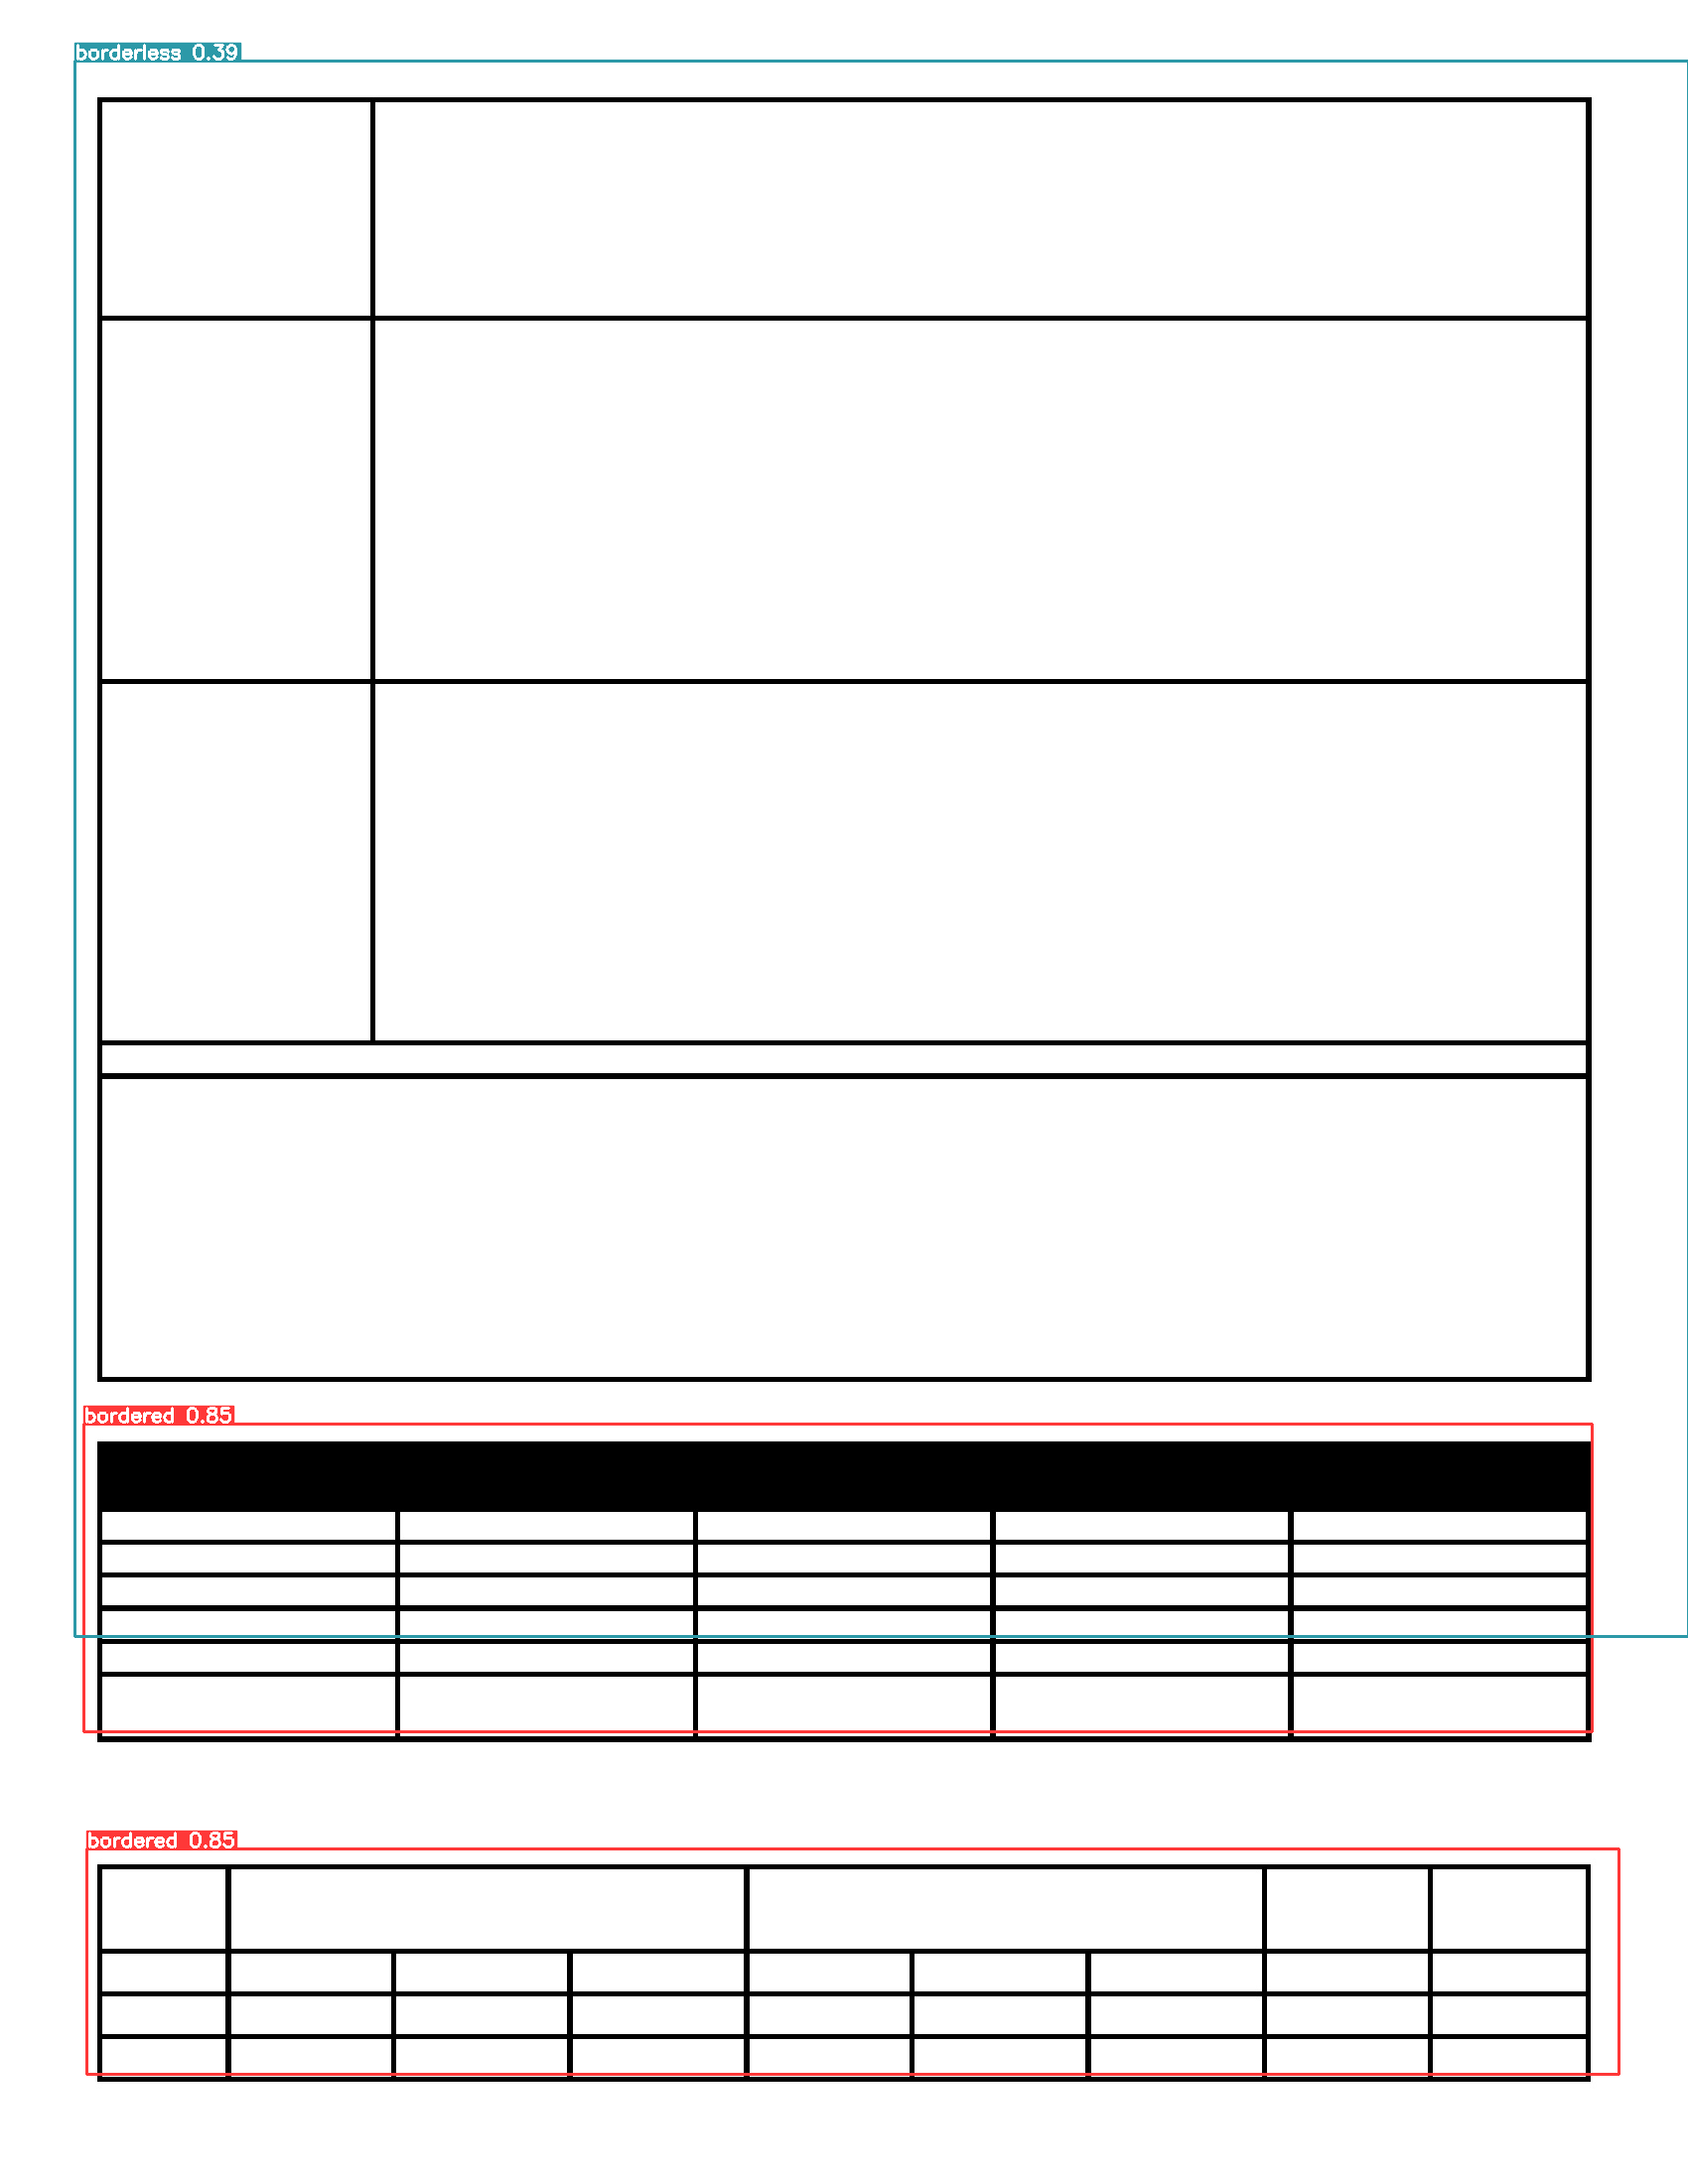

In [2]:
render

# ================= New Method using fine detection and parsing ==============

In [ ]:
pip install transformers datasets torch torchvision pandas pdf2image pytesseract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 1.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from transformers import DetrImageProcessor, TableTransformerForObjectDetection
import pandas as pd
from pdf2image import convert_from_path
import cv2
import numpy as np

# Load pre-trained Table Transformer model and image processor
processor = DetrImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

def extract_tables_from_image(image_path):
    """ Extracts table data from an image file. """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Preprocess image for Table Transformer
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # Filter detected objects that are classified as "table"
    boxes = outputs.logits.softmax(-1)[0, :, :-1]  # Remove the "background" class
    scores, labels = boxes.max(dim=1)
    table_indices = torch.where(labels == 1)[0]  # Assuming '1' corresponds to "table" class

    extracted_data = []

    for idx in table_indices:
        box = outputs.pred_boxes[0][idx].tolist()
        xmin, ymin, xmax, ymax = [int(coord) for coord in box]
        table_crop = image[ymin:ymax, xmin:xmax]
        
        # Use OCR (optional) to extract text from the table
        try:
            import pytesseract
            data = pytesseract.image_to_string(table_crop, config='--psm 6')
            extracted_data.append(data)
        except ImportError:
            print("pytesseract not installed. OCR step skipped.")

    return extracted_data

def extract_tables_from_pdf(pdf_path):
    """ Extracts table data from each page of the PDF file. """
    images = convert_from_path(pdf_path)
    all_tables = []

    for i, image in enumerate(images):
        image_path = f"page_{i+1}.jpg"
        image.save(image_path, 'JPEG')
        table_data = extract_tables_from_image(image_path)
        all_tables.extend(table_data)

    return all_tables

def save_to_csv(table_data, output_csv_path):
    """ Converts extracted table data into a CSV file. """
    df = pd.DataFrame(table_data)
    df.to_csv(output_csv_path, index=False)
    print(f"Saved table data to {output_csv_path}")

# Example usage
pdf_path = "example.pdf"  # Path to your PDF file
output_csv_path = "extracted_table.csv"

# Extract tables from PDF and save to CSV
table_data = extract_tables_from_pdf(pdf_path)
save_to_csv(table_data, output_csv_path)
